# The system

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, KNNBasic


## Part 1: Data Exploration and Preprocessing
### Including: Data Retrieval, Exploratory Data Analysis (EDA), Data Cleaning, & Feature Engineering

In [67]:
books = pd.read_csv("../data/user_data/Books.csv", low_memory=False)
ratings = pd.read_csv("../data/user_data/Ratings.csv")

In [68]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [69]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [70]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [71]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [72]:
print("Books:", books.shape)
print("Ratings:", ratings.shape)

Books: (271360, 8)
Ratings: (1149780, 3)


#### Clean the Books.csv dataset

In [73]:
#Fix column names

books.columns = books.columns.str.replace("-","_").str.replace(" ", "_")

In [74]:
#Remove invalid publication years

before = books.shape[0]

books['Year_Of_Publication'] = pd.to_numeric(books['Year_Of_Publication'], errors='coerce')
books = books[(books['Year_Of_Publication'] >=1800) & (books['Year_Of_Publication']<= 2025)]

after = books.shape[0]

print(f"Rows removed: {before-after}")

Rows removed: 4635


In [75]:
#Normalize book author and book titles

books['Book_Author'] = books['Book_Author'].str.strip().str.title()
books['Book_Title'] = books['Book_Title'].str.strip().str.title()

In [76]:
books.head()

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image_URL_S,Image_URL_M,Image_URL_L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision In Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story Of The Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies Of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [77]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Index: 266725 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 266725 non-null  object 
 1   Book_Title           266725 non-null  object 
 2   Book_Author          266723 non-null  object 
 3   Year_Of_Publication  266725 non-null  float64
 4   Publisher            266723 non-null  object 
 5   Image_URL_S          266725 non-null  object 
 6   Image_URL_M          266725 non-null  object 
 7   Image_URL_L          266725 non-null  object 
dtypes: float64(1), object(7)
memory usage: 18.3+ MB


In [78]:
books[books['Book_Author'].isna()]


,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image_URL_S,Image_URL_M,Image_URL_L
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999.0,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...
187689,9627982032,The Credit Suisse Guide To Managing Your Perso...,NaN,1995.0,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...


In [79]:
#Dropping those two rows because they do not matter

books = books.dropna(subset=["Book_Author"])

In [80]:
books[books['Publisher'].isna()]

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image_URL_S,Image_URL_M,Image_URL_L
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002.0,NaN,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...
129037,1931696993,Finders Keepers,Linnea Sinclair,2001.0,NaN,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...


In [81]:
#Also dropping those two rows because they do not matter

books = books.dropna(subset=["Publisher"])

In [82]:
#Removing books published by known foreign-language publishers
#Produce books in langauges I do not understand, so excluding them ensures the results remain interpretable

before = books.shape[0]

foreign_publishers = [
    "Goldmann",
    "Heyne",
    "Gallimard",
    "LÃ?Â¼bbe",
    "Distribooks",
    "Eichborn",
    "Diogenes Verlag",
    "Carlsen Verlag GmbH"
]

books = books[
    ~books['Publisher'].str.contains("|".join(foreign_publishers),case = False, na = False)
]

after = books.shape[0]

print(f"Rows removed: {before-after}")

Rows removed: 3970


In [83]:
#Removing Scholastic publisher since that is kids books

kids_books_publishers = [
    "Scholastic", "Random House Books for Young Readers"
]

books = books[
    ~books['Publisher'].str.contains("|".join(kids_books_publishers), case=False, na=False)]

In [84]:
books.info()

#Im happy with that, let's move on

<class 'pandas.core.frame.DataFrame'>
Index: 256956 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 256956 non-null  object 
 1   Book_Title           256956 non-null  object 
 2   Book_Author          256956 non-null  object 
 3   Year_Of_Publication  256956 non-null  float64
 4   Publisher            256956 non-null  object 
 5   Image_URL_S          256956 non-null  object 
 6   Image_URL_M          256956 non-null  object 
 7   Image_URL_L          256956 non-null  object 
dtypes: float64(1), object(7)
memory usage: 17.6+ MB


#### Cleaning the Ratings.csv dataset

In [85]:
#Looking at the distribution of ratings

ratings['Book-Rating'].value_counts().sort_index()

Book-Rating
0     716109
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: count, dtype: int64

In [86]:
#Dropping rows with rating = 0
#Those are instances where users clicked or viewed on the book but did not give a rating.
#Keeping the zeros will distort the algorithm 

#The dataset will still have ~400k+ ratings amount ~100k users that cover ~100k books

ratings['Book-Rating'] = pd.to_numeric(ratings['Book-Rating'], errors='coerce')
ratings = ratings[ratings['Book-Rating'] >0]

In [87]:
ratings['Book-Rating'].value_counts().sort_index()

Book-Rating
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: count, dtype: int64

In [88]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 433671 entries, 1 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      433671 non-null  int64 
 1   ISBN         433671 non-null  object
 2   Book-Rating  433671 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 13.2+ MB


In [89]:
#Fix column names

ratings.columns = ratings.columns.str.replace("-","_").str.replace(" ", "_")

In [90]:
ratings.head()

,User_ID,ISBN,Book_Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6


### Moving on to EDA

In [91]:
print("Books:", books.shape)
print("Ratings:", ratings.shape)

Books: (256956, 8)
Ratings: (433671, 3)


<Axes: >

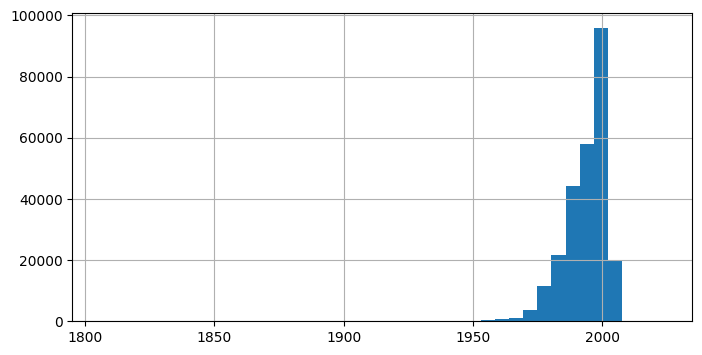

In [92]:
#Checking Publication Date for Outliers

books['Year_Of_Publication'].hist(bins=40, figsize=(8,4))

In [93]:
#As expected, there are outliers.
#Getting rid of rows with books published before 1950 for relevancy

books['Year_Of_Publication']= books['Year_Of_Publication'].clip(lower=1950,upper=2024)

<Axes: >

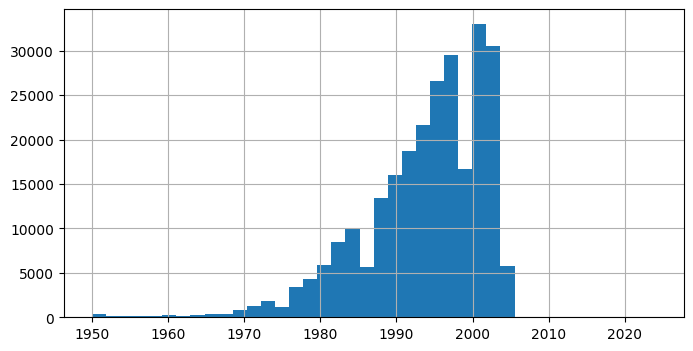

In [94]:
books['Year_Of_Publication'].hist(bins=40, figsize=(8,4))

#Looks much better

In [95]:
#Top 10 authors

books['Book_Author'].value_counts().head(10)

Book_Author
Agatha Christie         588
William Shakespeare     557
Stephen King            478
Francine Pascal         418
Carolyn Keene           372
Isaac Asimov            337
Barbara Cartland        308
Nora Roberts            298
Charles Dickens         294
Not Applicable (Na )    284
Name: count, dtype: int64

In [96]:
#Top 10 Publishers

books['Publisher'].value_counts().head(10)

Publisher
Harlequin                   7535
Silhouette                  4220
Pocket                      3870
Ballantine Books            3764
Bantam Books                3642
Simon &amp; Schuster        2965
Penguin Books               2843
Berkley Publishing Group    2767
Penguin USA                 2714
Warner Books                2703
Name: count, dtype: int64

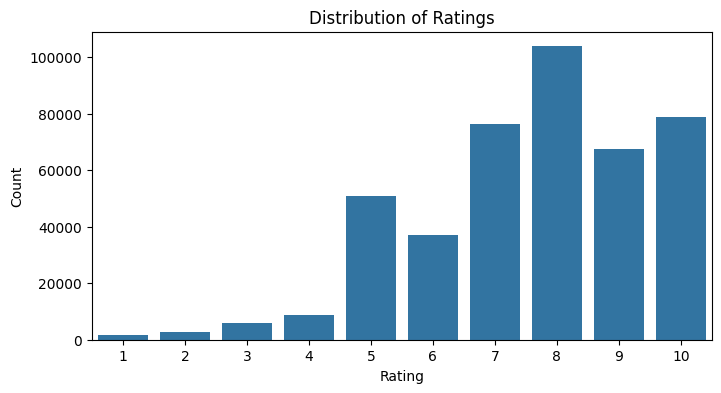

In [97]:
#Plot for distribution of Ratings

rating_counts = ratings['Book_Rating'].value_counts().sort_index()

plt.figure(figsize=(8,4))
sns.barplot(x=rating_counts.index, y=rating_counts.values)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()

In [98]:
#Number of ratings per user

ratings['User_ID'].value_counts().describe()

#This is highly skewed

count    77805.000000
mean         5.573819
std         44.001879
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       8524.000000
Name: count, dtype: float64

In [99]:
#I am worried the users that have contributed thousands of rankings will give bias to the model

ratings['User_ID'].value_counts().head(10)

#However, the system will be able to give better matches to users with more ratings
#Keeping them for now

User_ID
11676     8524
98391     5802
153662    1969
189835    1906
23902     1395
76499     1036
171118    1035
235105    1023
16795      968
248718     948
Name: count, dtype: int64

In [100]:
#Ratings per book

ratings['ISBN'].value_counts().describe()

#Outliers exist but it is not an error
#More popular books will have more rating

count    185973.000000
mean          2.331903
std           6.834667
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         707.000000
Name: count, dtype: float64

In [101]:
#Checking that all ISBNs in the ratings data also exists in the books data

missing_books = ~ratings['ISBN'].isin(books['ISBN'])
print(f"Books rated that are not in Books Data:", missing_books.sum())

#This a problem for when I merge the data, as the ISBNs not in the books data will not have any metadata

Books rated that are not in Books Data: 67439


In [102]:
#Removing the ratings with ISBN's that are not in the books data

ratings_clean = ratings[ratings['ISBN'].isin(books['ISBN'])]

In [103]:
#Now books and ratings data are ready to merge

ratings_merged = ratings_clean.merge(
    books,
    on='ISBN',
    how='inner'
)

ratings_merged.head()

,User_ID,ISBN,Book_Rating,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image_URL_S,Image_URL_M,Image_URL_L
0,276726,0155061224,5,Rites Of Passage,Judith Rae,2001.0,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
1,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
2,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...
3,276744,038550120X,7,A Painted House,John Grisham,2001.0,Doubleday,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...
4,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003.0,HarperTorch,http://images.amazon.com/images/P/0060517794.0...,http://images.amazon.com/images/P/0060517794.0...,http://images.amazon.com/images/P/0060517794.0...


In [104]:
print("Ratings Merged:", ratings_merged.shape)

ratings_merged.info()

Ratings Merged: (366232, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366232 entries, 0 to 366231
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User_ID              366232 non-null  int64  
 1   ISBN                 366232 non-null  object 
 2   Book_Rating          366232 non-null  int64  
 3   Book_Title           366232 non-null  object 
 4   Book_Author          366232 non-null  object 
 5   Year_Of_Publication  366232 non-null  float64
 6   Publisher            366232 non-null  object 
 7   Image_URL_S          366232 non-null  object 
 8   Image_URL_M          366232 non-null  object 
 9   Image_URL_L          366232 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 27.9+ MB


In [105]:
#Removing duplicate ratings as a sanity check

ratings_merged.drop_duplicates(['User_ID', 'ISBN'], keep='first', inplace=True)

ratings_merged.info()

#There were none

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366232 entries, 0 to 366231
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User_ID              366232 non-null  int64  
 1   ISBN                 366232 non-null  object 
 2   Book_Rating          366232 non-null  int64  
 3   Book_Title           366232 non-null  object 
 4   Book_Author          366232 non-null  object 
 5   Year_Of_Publication  366232 non-null  float64
 6   Publisher            366232 non-null  object 
 7   Image_URL_S          366232 non-null  object 
 8   Image_URL_M          366232 non-null  object 
 9   Image_URL_L          366232 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 27.9+ MB


In [106]:
#Filter books with enough ratings
#The CF KNN model will perform better

book_counts = ratings_merged['ISBN'].value_counts()
valid_books = book_counts[book_counts >= 5].index

ratings_filt = ratings_merged[ratings_merged['ISBN'].isin(valid_books)]

In [107]:
#Filter users with enough ratings
#Again, the CF KNN model will perform better

user_counts = ratings_filt['User_ID'].value_counts()
valid_users = user_counts[user_counts >= 5].index

ratings_filt= ratings_filt[ratings_filt['User_ID'].isin(valid_users)]

#### Create Modeling Matrices

In [108]:
#User-Item Rating Matrix
#For Collaborative Filtering

user_ids_f = ratings_filt['User_ID'].astype('category').cat.codes
book_ids_f = ratings_filt['ISBN'].astype('category').cat.codes
ratings_vals_f = ratings_filt['Book_Rating'].astype(float).values

user_item_sparse_f = csr_matrix(
    (ratings_vals_f, (user_ids_f, book_ids_f))
)

user_item_sparse_f

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 128993 stored elements and shape (7509, 13097)>

In [109]:
#Checking sparsity

print("shape:", user_item_sparse_f.shape)
print("nonzero entries:", user_item_sparse_f.count_nonzero())
print("sparsity:", 1 - (user_item_sparse_f.count_nonzero()/ np.prod(user_item_sparse_f.shape)))

shape: (7509, 13097)
nonzero entries: 128993
sparsity: 0.998688367372403


In [110]:
#Build an indexed version of books

isbn_categories = ratings_filt['ISBN'].unique()

books_indexed = books.drop_duplicates('ISBN').set_index('ISBN')

books_indexed.head()

,Book_Title,Book_Author,Year_Of_Publication,Publisher,Image_URL_S,Image_URL_M,Image_URL_L
ISBN,,,,,,,
0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
0060973129,Decision In Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
0374157065,Flu: The Story Of The Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
0393045218,The Mummies Of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [111]:
#Select only books used in ratings
#Return ISBN as a column

books_for_model = books_indexed.loc[books_indexed.index.isin(isbn_categories)].reset_index().rename(columns={'index':'ISBN'})

books_for_model['Book_Title'] = books_for_model['Book_Title'].fillna('')
books_for_model['Book_Author'] = books_for_model['Book_Author'].fillna('')
books_for_model['Publisher'] = books_for_model['Publisher'].fillna('')

books_for_model['text'] =(
    books_for_model['Book_Title'].fillna('') +''+
    books_for_model['Book_Author'].fillna('') +''+
    books_for_model['Publisher'].fillna('')
).str.lower()

books_for_model[['ISBN', 'text']].head()

,ISBN,text
0,0002005018,clara callanrichard bruce wrightharperflamingo...
1,0374157065,flu: the story of the great influenza pandemic...
2,0399135782,the kitchen god's wifeamy tanputnam pub group
3,0440234743,the testamentjohn grishamdell
4,0452264464,beloved (plume contemporary fiction)toni morri...


In [112]:
#Build TF-IDF Matrix
#Limiting vocab size to prevent memory explosion

tfidf = TfidfVectorizer(
    max_features=50000,
    stop_words='english',
    ngram_range=(1,2),
    min_df=2,
    strip_accents='unicode'
)

tfidf_matrix = tfidf.fit_transform(books_for_model['text'])

tfidf_matrix.shape

(13097, 15888)

## Part 2: Build the Recommendation System

#### Build the Content-Based Recommender

In [113]:
#Creating an easy way to find ISBN to row index

isbn_to_index = pd.Series(books_for_model.index, index=books_for_model['ISBN'])

In [114]:
#Inspect top TF-IDF term

feature_names = tfidf.get_feature_names_out()

term_weights = tfidf_matrix.sum(axis=0).A1

N = 20 
top_idx = term_weights.argsort()[::-1][:N]

top_terms = [(feature_names[i], term_weights[i]) for i in top_idx]

top_terms

[('books', 676.3352178078457),
 ('publishing', 201.23247929243567),
 ('book', 184.56779706572115),
 ('group', 152.96713028949313),
 ('press', 146.21755207908922),
 ('publishing group', 132.92680265583613),
 ('amp', 113.0686198353314),
 ('house', 99.00593338050193),
 ('company', 94.21015623841632),
 ('usa', 94.11295961660593),
 ('paperback', 90.9953387601194),
 ('classics', 70.35735273818638),
 ('martin', 67.68545913801675),
 ('publishing company', 62.637120215931375),
 ('books usa', 61.590999505411325),
 ('rey', 56.9421320597212),
 ('love', 53.35695226705602),
 ('novel', 52.75684453104311),
 ('life', 50.630434091511994),
 ('mysteries', 49.90157939492231)]

In [115]:
#Recommender function 

def recommend_content(isbn, top_n=10):
    idx = isbn_to_index [isbn]
    
    book_vec = tfidf_matrix[idx]
    
    sims = cosine_similarity(book_vec, tfidf_matrix).flatten()
    
    similar_idx = sims.argsort()[::-1][1:top_n+1]
    
    results = books_for_model.iloc[similar_idx][['ISBN', 'Book_Title', 'Book_Author', 'Publisher']].copy()

    results['similarity'] = sims[similar_idx]
    
    return results.reset_index(drop=True)

In [116]:
#Test the recommender

sample_isbn = books_for_model['ISBN'].iloc[0]
recommend_content(sample_isbn)

,ISBN,Book_Title,Book_Author,Publisher,similarity
0,0446611859,The Proving Ground,G. Bruce Knecht,Warner Books,0.557396
1,1550546007,Why I Hate Canadians,Will Ferguson,Harpercollins Canada,0.551416
2,1550544683,Jade Peony,Wayson Choy,Harpercollins Canada,0.382301
3,848300268X,Dones (Colâ¨Lecciã³ Clã Ssica),Isabel-Clara Simã³,Columna,0.363584
4,0143012738,The Corner Garden,Lesley Krueger,Penguin Books Canada,0.301235
5,0679312064,Dropped Threads 2: More Of What We Aren'T Told,Carol Shields,Vintage Books Canada,0.295641
6,055357549X,Holy Fire: A Novel (Bantam Spectra Book),Bruce Sterling,Bantam Books,0.223265
7,1576738159,The Prayer Of Jabez For Teens (The Breakthroug...,Bruce Wilkinson,Multnomah,0.211253
8,0307010368,Snow White And The Seven Dwarfs,Little Golden Staff,Random House of Canada,0.186230
9,0892967307,The Red Room,Nicci French,Mysterious Press,0.000000


#### Collaborative Filtering Model

In [117]:
#Using surprise library
#It was specifically built for CF recommender systems

reader = Reader(rating_scale=(1,10))

data = Dataset.load_from_df(
    ratings_filt[['User_ID', 'ISBN', 'Book_Rating']],
    reader
)

trainset = data.build_full_trainset()

In [118]:
#Train an item-based cosine KNN model

sim_options = {
    'name': 'cosine',
    'user_based': False
}

algo = KNNBasic(sim_options= sim_options)
trainset = data.build_full_trainset()
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [119]:
#Create mapping of ISBN to surprise internal ID

surprise_isbns = {trainset.to_raw_iid(iid) for iid in trainset.all_items()}

isbn_to_inner = {
    raw: trainset.to_inner_iid(raw)
    for raw in surprise_isbns
}

In [120]:
#Recommendation function
#Given an ISBN -> recommend similar books -> based on user rating patterns

def recommend_cf(isbn, top_n =10):
    if isbn not in isbn_to_inner:
        return f"ISBN {isbn} has no user ratings"
    
    inner_id = isbn_to_inner[isbn]

    neighbors_inner = algo.get_neighbors(inner_id, k=top_n)

    neighbor_isbns = [trainset.to_raw_iid(n) for n in neighbors_inner]

    recs = books_indexed.loc[neighbor_isbns][['Book_Title', 'Book_Author', 'Publisher']].copy()
    recs = recs.reset_index().rename(columns={'index': 'ISBN'})
   
    return recs

In [121]:
#Test the CF Model

sample_isbn = ratings_filt['ISBN'].iloc[0]
recommend_cf(sample_isbn)

,ISBN,Book_Title,Book_Author,Publisher
0,0140154078,The Music Of Chance,Paul Auster,Penguin Books
1,063403541X,Bridget Jones'S Diary: Music From The Motion P...,Various,Hal Leonard Publishing Corporation
2,8420432113,Momo (Spanish Language Edition),Michael Ende,Aguilar
3,950491036X,La Sombra Del Viento,Carlos Ruiz Zafon,Planeta
4,0345354621,The Terminal Man,Michael Crichton,Ballantine Books
5,0684867621,The Girl Who Loved Tom Gordon : A Novel,Stephen King,Scribner
6,0446611212,Violets Are Blue,James Patterson,Warner Vision
7,0316154059,City Of Bones,Michael Connelly,Warner Books
8,0345452550,A Cold Heart: An Alex Delaware Novel,Jonathan Kellerman,Ballantine Books
9,0399146504,The Devil'S Code,John Sandford,G. P. Putnam's Sons


In [122]:
#Double checking CF model

sample = ratings_filt['ISBN'].sample(1).iloc[0]
recommend_cf(sample)

,ISBN,Book_Title,Book_Author,Publisher
0,8420432113,Momo (Spanish Language Edition),Michael Ende,Aguilar
1,950491036X,La Sombra Del Viento,Carlos Ruiz Zafon,Planeta
2,0425104273,The First Deadly Sin,Lawrence Sanders,Berkley Publishing Group
3,0399146504,The Devil'S Code,John Sandford,G. P. Putnam's Sons
4,0399146687,Perish Twice,Robert B. Parker,Putnam Publishing Group
5,0399147101,Potshot,Robert B. Parker,G. P. Putnam's Sons
6,0399148337,Midnight Runner,Jack Higgins,Putnam Publishing Group
7,0399148728,Fire Ice: A Novel From The Numa Files,Clive Cussler,Putnam Publishing Group
8,0399150811,"Retreat, Hell",W. E. B. Griffin,Putnam Publishing Group
9,0425183181,A Little Magic,Nora Roberts,Berkley Publishing Group


#### Build Hybrid Recommender
Combination of:

Content-based similarity - TF-IDF + Author + publisher

Collaborative filtering similarity - Surprise item-item cosine

In [123]:
#Get content similarity for a single ISBN

def get_content_similarities(isbn):
    if isbn not in isbn_to_index.index:
        return None
    
    idx = isbn_to_index[isbn]

    book_vec = tfidf_matrix[idx]

    sims = cosine_similarity(book_vec, tfidf_matrix).flatten()
    return sims

In [124]:
#Get CF similarity vector for the same ISBN

def get_cf_similarities(isbn, top_k=50):
    if isbn not in isbn_to_inner:
        return None
    
    inner_id = isbn_to_inner[isbn]

    neighbors_inner = algo.get_neighbors(inner_id, k=top_k)

    sim_vector = np.zeros(len(books_for_model), dtype=float)

    for n in neighbors_inner:
        sim = algo.sim[inner_id, n]
        raw_isbn = trainset.to_raw_iid(n)
    
        if raw_isbn in isbn_to_index.index:
            idx = isbn_to_index[raw_isbn]
            sim_vector[idx] = sim

    if sim_vector.max() > sim_vector.min():
        sim_vector= (sim_vector -sim_vector.min() / (sim_vector.max() - sim_vector.min()))

    return sim_vector

In [125]:
#Hybrid Function
#Also removes books the reader already rated (they read the book)

def recommend_hybrid_user(isbn, user_id, top_n=10, alpha=0.6):
    content_sims = get_content_similarities(isbn)
    cf_sims = get_cf_similarities(isbn)
    
    content_norm = content_sims / (content_sims.max() + 1e-6)
    cf_norm = cf_sims / (cf_sims.max() + 1e-6)

    hybrid_sims = alpha * content_norm + (1- alpha) * cf_norm
    
    hybrid_sims[isbn_to_index[isbn]] =0 

    user_rated = ratings_filt.loc[ratings_filt['User_ID'] == user_id, 'ISBN']
    user_rated_idx = isbn_to_index[user_rated.dropna()].values
    hybrid_sims[user_rated_idx] = 0

    top_idx = hybrid_sims.argsort()[::-1][:top_n]

    results = books_for_model.iloc[top_idx][['ISBN', 'Book_Title', 'Book_Author', 'Publisher']].copy()
    results['hybrid_score'] = hybrid_sims[top_idx]

    return results.reset_index(drop=True)

In [126]:
#Funtion that displays recs nicely

def show_hybrid_recs_user(isbn, user_id, top_n=10, alpha=0.6):
    book = books_for_model.loc[books_for_model['ISBN'] ==isbn].iloc[0]

    print("Book Read:")
    print(f"Title: {book['Book_Title']}")
    print(f"Author: {book['Book_Author']}")

    r = ratings_filt[
        (ratings_filt['ISBN'] == isbn) &
        (ratings_filt['User_ID'] == user_id)
        ].iloc[0]['Book_Rating']
    
    print(f"User Rating: {r}\n")

    print("\nTop 10 Recommendations:")
    recs = recommend_hybrid_user(isbn, user_id, top_n=top_n, alpha=alpha)
    display(recs)

In [127]:
#Test the hybrid model

#Pick a book a user read and rated

row = ratings_filt.sample(1).iloc[0]
user_id = row['User_ID']
isbn = row['ISBN']
user_rating = row['Book_Rating']

show_hybrid_recs_user(isbn, user_id, top_n=10, alpha=0.6)

Book Read:
Title: The Homing
Author: John Saul
User Rating: 10


Top 10 Recommendations:


,ISBN,Book_Title,Book_Author,Publisher,hybrid_score
0,0449223043,Guardian,John Saul,Fawcett Books,0.475082
1,0756400619,The Serpent'S Shadow,Mercedes Lackey,Daw Books,0.413032
2,0345337662,Interview With The Vampire,Anne Rice,Ballantine Books,0.412697
3,0812532619,The Call Of Earth,Orson Scott Card,Tor Books,0.412598
4,0452284449,The Virgin Blue,Tracy Chevalier,Plume Books,0.411441
5,034540288X,The Lost World,Michael Crichton,Ballantine Books,0.411276
6,0345386108,Winter Moon,Dean R. Koontz,Ballantine Books,0.409137
7,0345370775,Jurassic Park,Michael Crichton,Ballantine Books,0.409018
8,0446672211,Where The Heart Is (Oprah'S Book Club (Paperba...,Billie Letts,Warner Books,0.408184
9,0316601950,The Pilot'S Wife : A Novel,Anita Shreve,Back Bay Books,0.407310


In [130]:
#Double check 

#Pick a book a user read and rated

row = ratings_filt.sample(1).iloc[0]
user_id = row['User_ID']
isbn = row['ISBN']
user_rating = row['Book_Rating']

show_hybrid_recs_user(isbn, user_id, top_n=10, alpha=0.6)

Book Read:
Title: Scarlett : The Sequel To Margaret Mitchell'S \Gone With The Wind\""
Author: Alexandra Ripley
User Rating: 6


Top 10 Recommendations:


,ISBN,Book_Title,Book_Author,Publisher,hybrid_score
0,0446515078,Scarlett: The Sequel To Margaret Mitchell'S Go...,Alexandra Ripley,Warner Books Inc,0.559701
1,0440236738,Gone For Good,Harlan Coben,Dell,0.461108
2,0553573926,Vertical Run,Joseph R. Garber,Bantam Books,0.440464
3,0441627404,The Once And Future King,T. H. White,Ace Books,0.409774
4,0345354621,The Terminal Man,Michael Crichton,Ballantine Books,0.405988
5,0385424736,The Rainmaker,John Grisham,Doubleday Books,0.405846
6,0452284449,The Virgin Blue,Tracy Chevalier,Plume Books,0.405579
7,0446600415,The Day After Tomorrow,Allan Folsom,Warner Books,0.404843
8,0316154059,City Of Bones,Michael Connelly,Warner Books,0.404070
9,0446350982,Presumed Innocent,Scott Turow,Warner Books,0.403867
